In [1]:
import numpy as np
import torch
from torch.autograd import Variable
import pyro
import pyro.infer
import pyro.optim
import pyro.distributions as dist

%matplotlib inline
import matplotlib.pyplot as plt 

torch.manual_seed(101)

/Users/hoondori/anaconda/envs/py2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


# Inference in pyro: From Stochastic Functions to Marginal Distributions

* stochastic function induce a joint dist p(y,z|x) over latent variables z and return y
* joint dist induce a marginal dist over return values of the function
* inference is constructing marginal distribution given an arbitaray boolean constraint
* baysian inference admit tractable approximations


## Simple Example

* weight: latent variable, x
* measurement : output varaible, y

In [2]:
def scale(guess):
    # prior
    weight = pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))
    # measurement fluctuates around the true weight
    return pyro.sample("measurement", dist.normal, weight, Variable(torch.Tensor([0.75])))

In [3]:
posterior = pyro.infer.Importance(scale, num_samples=100)

In [4]:
guess = Variable(torch.Tensor([8.5]))
marginal = pyro.infer.Marginal(posterior)
print(marginal(guess))

Variable containing:
 10.0699
[torch.FloatTensor of size 1]



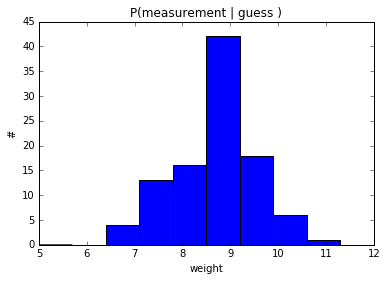

In [5]:
plt.hist([marginal(guess).data[0] for _ in range(100)], range=(5.0,12.0))
plt.title("P(measurement | guess )")
plt.xlabel("weight")
plt.ylabel("#")

#plt.show()

## Conditioning Models on Data

* give evidence like measurement == sth
* by pyro.condition, pyro.sample with obs, pyro.observe

{'weight': Variable containing:
 5.3855
[torch.FloatTensor of size 1]
}


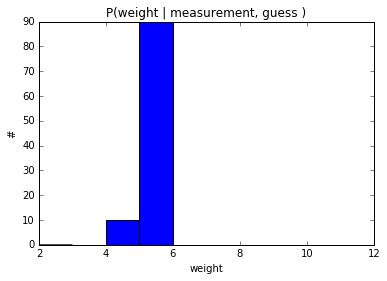

In [6]:
guess = Variable(torch.Tensor([3.5]))   # very wrong
measurement_observed = Variable(torch.Tensor([9.5]))
                      
conditioned_scale = pyro.condition(scale, data={"measurement": measurement_observed})
                                
marginal = pyro.infer.Marginal(pyro.infer.Importance(conditioned_scale, num_samples=100), sites=["weight"])

print(marginal(guess))

plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(2.0,12.0))
plt.title("P(weight | measurement, guess )")
plt.xlabel("weight")
plt.ylabel("#")


* guess가 true dist에 비해서 현져하게 다르다면 이는 매우 비효율적인 상황
* guide function should generally be chosen so that it closely approximates the dist over all unobserved sample statements in the model

### Prior를 Guide function으로 줘 보기

{'weight': Variable containing:
 6.3266
[torch.FloatTensor of size 1]
}


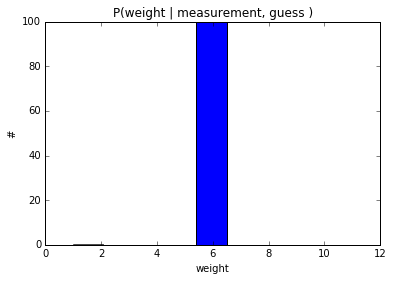

In [7]:
guess = Variable(torch.Tensor([3.5]))   # very wrong guide 
measurement_observed = Variable(torch.Tensor([9.5]))
                      
conditioned_scale = pyro.condition(scale, data={"measurement": measurement_observed})
                      
def scale_prior_guide(guess):
    return pyro.sample("weight", dist.normal, guess, Variable(torch.ones(1)))

posterior = pyro.infer.Importance(conditioned_scale, guide=scale_prior_guide, num_samples=100)
marginal = pyro.infer.Marginal(posterior, sites=["weight"])

print(marginal(guess))

plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(1.0,12.0))
plt.title("P(weight | measurement, guess )")
plt.xlabel("weight")
plt.ylabel("#")

### guess와 measurement 를 모두 고려한 guide function 사용

{'weight': Variable containing:
 7.1529
[torch.FloatTensor of size 1]
}


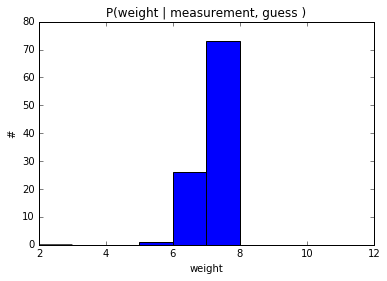

In [8]:
guess = Variable(torch.Tensor([3.5]))   # very wrong guide 
measurement_observed = Variable(torch.Tensor([9.5]))

def deferred_conditioned_scale(measurement, *args, **kwargs):
    return pyro.condition(scale, data={"measurement": measurement})(*args, **kwargs)
                      
def scale_posterior_guide(measurement, guess):
    a = (guess + torch.sum(measurement)) / (measurement.size(0) +1.0)
    b = Variable(torch.ones(1)) / (measurement.size(0)+1.0)
    return pyro.sample("weight", dist.normal, a, b)

posterior = pyro.infer.Importance(deferred_conditioned_scale, guide=scale_posterior_guide, num_samples=100)
marginal = pyro.infer.Marginal(posterior, sites=["weight"])

print(marginal(measurement_observed, guess))

plt.hist([marginal(measurement_observed, guess)["weight"].data[0] for _ in range(100)], range=(2.0,12.0))
plt.title("P(weight | measurement, guess )")
plt.xlabel("weight")
plt.ylabel("#")

## Automated Variational Inference in Probabilistic Programming

* It is easy to sample from the prior p(x) defined by a probabilistic program: simply run the program
* But inference in such languages is hard: given a known value of a subset y of the variables, inference must essentially run the program ‘backwards’ to sample from p(x|y).
  * weight 예제에서는, p(x|y=9.5)
* Variational inference offers a powerful, deterministic approximation to exact Bayesian inferencein complex distributions.

![](./images/02/01.png)

![](./images/02/02.png)

![](./images/02/03.png)

![](./images/02/04.png)

![](./images/02/05.png)

![](./images/02/06.png)

![](./images/02/07.png)


## Parameterized Stochastic Functions and Variational Inference

* pyro.parm을 이용해서 위에서 언급한 일종의 variational program 틀을 만든다.
* optim 을 이용해서 variational program의 parameter를 업데이트한다. 
* 찾은 최적화된 parameter를 가진 guide를 가지고
  * Importance sampling에 guide로 활용해도 되고
  * 직접 guide 자체에서 sampling을 해도 된다.

In [15]:
def scale_parametrized_guide(guess):
    a = pyro.param("a", Variable(torch.randn(1) + guess.data.clone(), requires_grad=True))
    b = pyro.param("b", Variable(torch.randn(1), requires_grad=True))
    return pyro.sample("weight", dist.normal, a, torch.abs(b))

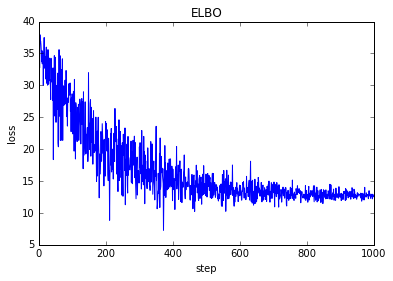

In [16]:
pyro.clear_param_store()
svi = pyro.infer.SVI(model=conditioned_scale,
                     guide=scale_parametrized_guide,
                     optim=pyro.optim.SGD({"lr": 0.001}),
                     loss="ELBO")

losses = []
for t in range(1000):
    losses.append(svi.step(guess))

plt.plot(losses)
plt.title("ELBO")
plt.xlabel("step")
plt.ylabel("loss")

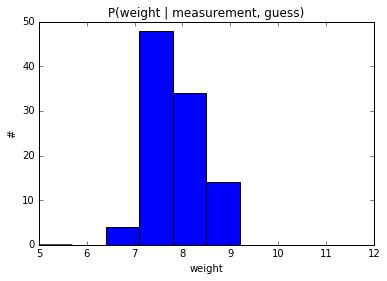

In [20]:
posterior = pyro.infer.Importance(conditioned_scale, scale_parametrized_guide, num_samples=10)
marginal = pyro.infer.Marginal(posterior, sites=["weight"])

plt.hist([marginal(guess)["weight"].data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")

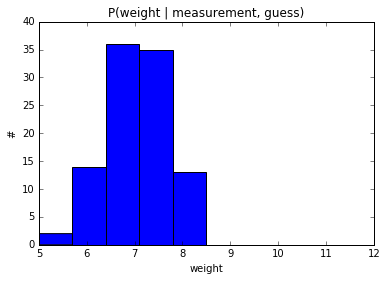

In [21]:
plt.hist([scale_parametrized_guide(guess).data[0] for _ in range(100)], range=(5.0, 12.0))
plt.title("P(weight | measurement, guess)")
plt.xlabel("weight")
plt.ylabel("#")